In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [3]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [4]:
def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    
    def policy_fn(observation):
        A = np.zeros(len(Q[observation]), dtype=float)
        idx = np.argmax(Q[observation])
        A[idx] = 1.0
        return A
        # Implement this!
    return policy_fn

In [5]:
def td_lambda_thing(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Nubmer of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Lambda discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    eligibility_factor=.8
    alpha=.3
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    target_policy = create_greedy_policy(Q)
    
    for i_episode in range(1, num_episodes+1):
        E = defaultdict(float)
        state = env.reset()
        action_probs = behavior_policy(state)
        action = np.random.choice(range(len(action_probs)),p=action_probs)
        done = False
        while not done:
            #print state
            #print action
            next_state, reward, done, _ = env.step(action)
            for k in E:
                E[k] *= discount_factor*eligibility_factor
            
            E[(state, action)] += 1
            next_action_probs = behavior_policy(next_state)
            next_action = np.random.choice(range(len(next_action_probs)), p=next_action_probs)
            delta = reward + discount_factor*Q[(next_state, next_action)] - Q[(state, action)]
            Q[(state, action)] += alpha*delta*E[(state, action)]
            state = next_state
            action = next_action
            #target_policy = create_greedy_policy(Q)
        #print i_episode
    # Our greedily policy we want to learn
    
    #print E
    # Implement this!
        
    return Q, target_policy

In [8]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Nubmer of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Lambda discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # The cumulative denominator of the weighted importance sampling formula
    # (across all episodes)
    C = defaultdict(lambda: np.zeros(env.action_space.n))
    
    target_policy = create_greedy_policy(Q)
    
    for i_episode in range(1, num_episodes+1):
        episode = []
        state = env.reset()
        
        done = False
        while not done:
            probs = behavior_policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            state = next_state
        G = 0.0
        W = 1.0   
        for t in range(len(episode))[::-1]:
            state, action, reward = episode[t]
            G = discount_factor*G+reward
            C[state][action] += W
            Q[state][action] += (W / C[state][action]) * (G - Q[state][action])
            if action != np.argmax(target_policy(state)):
                break
            W = W * 1./behavior_policy(state)[action]
            
        return Q, target_policy

In [9]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=50000, behavior_policy=random_policy)

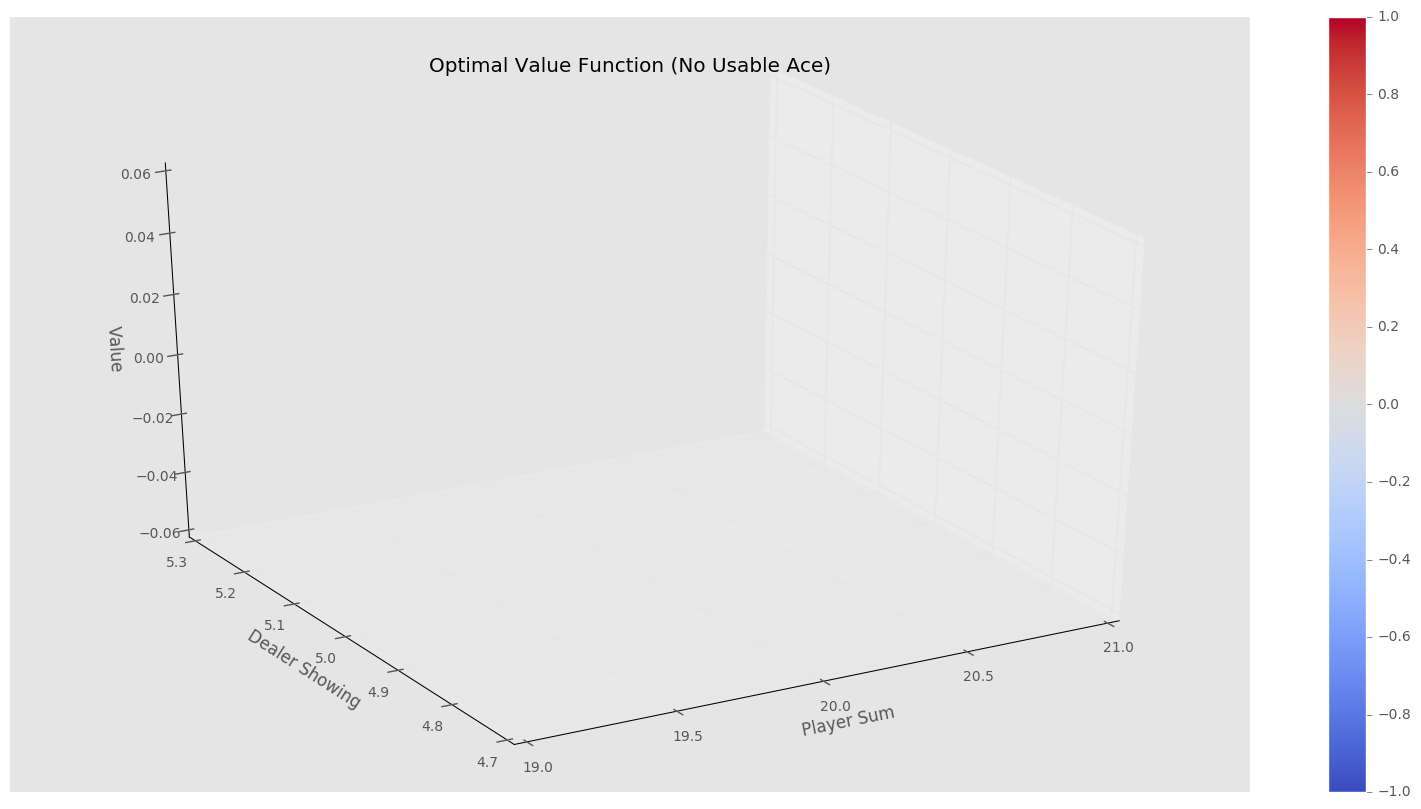

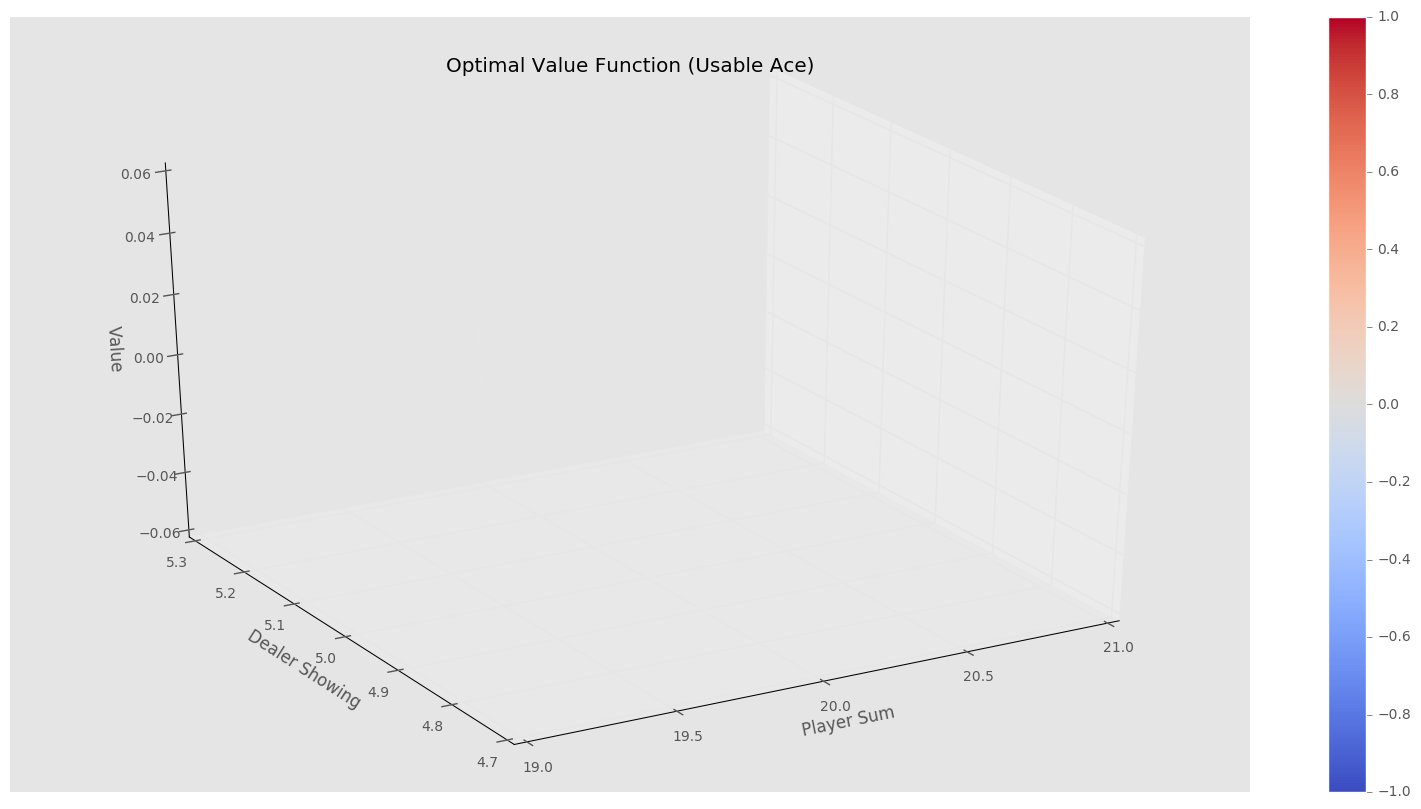

In [11]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    #print state
    #state2 = state[0]
    #print action_values
    action_value = np.max(action_values)
    V[state] = action_value
    #print V
    #print action_value
plotting.plot_value_function(V, title="Optimal Value Function")